# Support Vector Machine with SDAE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd

# Classifier
from sklearn.svm import SVC

# Character N-gram feature extractor
from sklearn.feature_extraction.text import CountVectorizer

# Util
from data_io import get_book
import torch
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

# Keras 
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam

# Plotting
import matplotlib.pyplot as plt

import tensorflow as tf

**Create the training, test and validation sets**


In [3]:
train_data = pd.concat(pd.read_csv("train.csv", chunksize = 100))
test_data = pd.concat(pd.read_csv("test.csv", chunksize = 100))
val_data = pd.concat(pd.read_csv("val.csv", chunksize = 100))

cv = CountVectorizer(analyzer='char', ngram_range=(1, 5), dtype=np.float32, max_features=10000)
X_train, X_test, X_val = cv.fit_transform(train_data.text.tolist()), cv.transform(test_data.text.tolist()), cv.transform(val_data.text.tolist())  
Y_train, Y_test, Y_val = train_data.author.tolist(), test_data.author.tolist(), val_data.author.tolist()

**Turn labelled data into numbers**

In [4]:
Encoder = LabelEncoder()
Y_train = Encoder.fit_transform(Y_train)
Y_test = Encoder.transform(Y_test)
Y_val = Encoder.transform(Y_val)

print(np.array(Y_train))

[25  5 29  5 13  5 25  0  3 25  5 29  8  3 25 25 25 25 25 25 11 25 15 15
 13 13 25 25  3 29 13 13 24 24 24 24 24 24 24 24 13 13 29 23 17 20 13 24
 24 24 24 24 24 24 24 24 24 25 13 11 13 13 20 13 24 24 24 24 24 24 24 27
 11 11 13  7  7  8 24 24 24  7  7  5  5  5 15 13 11 13  7 13 23 25  7 13
  7  7 15  7 27  7  7  7  7 14 28 28  7  7  7  7  7  7  7  7  5  5  7  7
  7 27 11 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 11
 27 27 27 27 27 27 27 11 28  4 29  4  4  5 11 29 20  3 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17  0
  7 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 13 26 23 11  5 29 12 12  5 25  5 23  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4 11 27 13  0 27 20 27
 28 27 28 27 27 27 23 15 15 15 23 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22  7 23 23 11 16 23 23 23
 23 23 23 29  9 27 27  1 15 27 27 27 15 27 16 14 14

**Just seeing the distribution of data**

In [5]:
print(X_train.shape)
# print(cv.vocabulary_)
print(len(train_data.text.tolist()[1].split(" ")))

one_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 1]
print("total occurrences of length 1 char n-gram")
print(sum(one_ngram_occurrences))
print("total amount of length 1 char n-gram")
print(len(one_ngram_occurrences))

two_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 2]
print("total occurrences of length 2 char n-gram")
print(sum(two_ngram_occurrences))
print("total amount of length 2 char n-gram")
print(len(two_ngram_occurrences))

three_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 3]
print("total occurrences of length 3 char n-gram")
print(sum(three_ngram_occurrences))
print("total amount of length 3 char n-gram")
print(len(three_ngram_occurrences))

four_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 4]
print("total occurrences of length 4 char n-gram")
print(sum(four_ngram_occurrences))
print("total amount of length 4 char n-gram")
print(len(four_ngram_occurrences))

five_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 5]
print("total occurrences of length 5 char n-gram")
print(sum(five_ngram_occurrences))
print("total amount of length 5 char n-gram")
print(len(five_ngram_occurrences))

(895, 10000)
75207
total occurrences of length 1 char n-gram
160679
total amount of length 1 char n-gram
27
total occurrences of length 2 char n-gram
2207052
total amount of length 2 char n-gram
391
total occurrences of length 3 char n-gram
11417695
total amount of length 3 char n-gram
2117
total occurrences of length 4 char n-gram
19609110
total amount of length 4 char n-gram
3906
total occurrences of length 5 char n-gram
16600464
total amount of length 5 char n-gram
3559


**Scale the data using min max normalizer**

In [6]:
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, X_val = X_train.toarray(), X_test.toarray(), X_val.toarray()

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

print(X_train_scaled)

[[0.04055664 0.04499426 0.04561904 ... 0.01246106 0.01247077 0.00453858]
 [0.04528183 0.04553762 0.05003038 ... 0.02959501 0.02961808 0.05143721]
 [0.02596131 0.02751357 0.02739256 ... 0.0046729  0.00467654 0.01361573]
 ...
 [0.03505723 0.04051569 0.03605674 ... 0.00311526 0.00311769 0.01512859]
 [0.03016631 0.02756297 0.02950577 ... 0.02258567 0.02260327 0.00907716]
 [0.01331787 0.01468159 0.01183401 ... 0.00155763 0.00155885 0.00605144]]


**First, just apply SVM on the raw input without encoding with autoencoders**

In [7]:
svm = SVC(kernel='linear', C=1)
svm.fit(X_train_scaled, Y_train)

preds = svm.predict(X_test_scaled)

print(Y_test)
print("############################################")
print(preds)
print("SVM Accuracy Score on test -> ", metrics.accuracy_score(preds, Y_test)*100)

print("SVM Accuracy Score on training -> ", metrics.accuracy_score(svm.predict(X_train_scaled), Y_train)*100)

print("SVM Accuracy Score on validation -> ", metrics.accuracy_score(svm.predict(X_val_scaled), Y_val)*100)

[ 3 11  5 25 13 25  4  3 25 25 25  3 29 11 15 29 25  5 13 13  3 24 24 24
 13 13 13 13 29 11 14 23 11 24 24 24 13 24 24 24 24 24 29 20 20 11  5  7
  7 24 24  7  5  5 13 13  7  7  7 19  7  7 11  7  7 28 28  7  7 27 28 28
 28 28 28 28 28 28 28 28 28 27 27  5  4  9  4  4 29  4  4 29 23  5 17 17
 17 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 23 26 12 12  3  4  4  4  4  4  4 27 27 27 15 26 27  0 23 15 15 15
 23 16 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 26 29 23 26 13  0 23
 23 23  9 23 23 23 27 27 27 27 27 29  9 12 27 14 14 14 14 14 14 14 14 14
 14 14 14  8  8 27 27 15 15 14  9  5 20 15 15 15 15  8  8  8  8  8  8  8
  8  8  9 14 20 20 19  3 20  5 20 15 25 13  0  5 29 29  9  7 29  5 20  4
 15 21  7 16 26 16 21 11 11 20 11 20 20  9 15 26  0  9  6  6 26  6  6 10
 10 10  6  1  1  1  1  1  1  1  1  1  1  1 21 11 13  3 23 16 24 10 10 10
 10  1 21  1  6 10  1  6 10 10 21 21 21 10 21 16  1 21 21 10  6 21 16  3
  6 25 25 19 16  0  0  9  0 26 21 26  0 19 11 28 16

**Code for the stacked denoising autoencoders**
==

**Class for tying weights in a denoising auto encoder**

In [8]:
# Code referenced from https://medium.com/@lmayrandprovencher/building-an-autoencoder-with-tied-weights-in-keras-c4a559c529a2

class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
  
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

**Class for construction of a denoising autoencoder**

In [30]:
np.random.seed(55)
class DenoisingAutoEncoder:
    def __init__(self, layers, corruption, activate_encoder, activate_decoder):
        self.layers = layers
        self.corruption = corruption
        self.activate_encoder = activate_encoder
        self.activate_decoder = activate_decoder
        self.history = None
  
    def forward(self, X_train, X_val, epochs, batch_size):
        # Step 1, Add binomial noise
        X_train_noisy = self.inject_noise(X_train)

        # Step 2, Encode X_train_noisy using sigmoid
        encoder_input = Input(shape = (X_train_noisy.shape[1], ))
        encoder = Dense(self.layers[0], activation=self.activate_encoder)
        final_encoder = encoder(encoder_input)

        # Step 3, Decode X_train_noisy using sigmoid
        # Tie the weights between the encoder and decoder layers
        decoder = DenseTranspose(encoder, activation=self.activate_decoder)
        final_decoder = decoder(final_encoder)

        # Step 4, cross entropy loss for normalised data and adam optimizer (Not sure what optimizer the paper uses)
        autoencoder = Model(encoder_input, final_decoder)
        autoencoder.compile(loss = 'binary_crossentropy', optimizer = 'adam')

        # Train it
        self.history = autoencoder.fit(X_train_noisy, X_train, batch_size = batch_size, epochs = epochs, validation_data=(X_val, X_val))
        autoencoder.summary()

        # Get the model that maps input to its encoded representation
        encoder_model = Model(encoder_input, final_encoder)

        # Return the (encoding model, encoding function)
        return (encoder_model, encoder)

    def inject_noise(self, x):
        # inject binomial noise since this model assumes you are normalising input 
        # with min max normalisation
        mask = np.random.choice([0, 1], size=x.shape, p=[self.corruption, 1-self.corruption])
        X_noisy = x * mask
        return X_noisy

**Class for construction of a stacked denoising autoencoder**

In [45]:
# For picking the best model while fine-tuning
from tensorflow.keras.callbacks import ModelCheckpoint

In [46]:
class StackedDenoisingAutoEncoder():
  def __init__(self, layers, corruption, activate_encoder, activate_decoder):
    self.layers = layers
    self.corruption = corruption
    self.activate_encoder = activate_encoder
    self.activate_decoder = activate_decoder
    self.encoding_funcs = []
    self.encoder_layers = []
    self.history = None
  
  def pretrain(self, X_train, X_val, epochs, batch_size):
    # self.layers contains the units each denoising autoencoder should take in
    learnt_input = X_train
    encoded_validation = X_val
    for layer in self.layers:
      autoencoder = DenoisingAutoEncoder([layer], self.corruption, self.activate_encoder, self.activate_decoder)
      (encoding_function, encoder) = autoencoder.forward(learnt_input, encoded_validation, epochs, batch_size)
      learnt_input = encoding_function.predict(learnt_input)
      encoded_validation = encoding_function.predict(encoded_validation)

      self.encoding_funcs.append(encoding_function)
      self.encoder_layers.append(encoder)

    self.history = autoencoder.history

  def finetune(self, X_train, Y_train, X_val, Y_val, epochs, batch_size):
    encoder_input = Input(shape = (X_train.shape[1], ))

    final_encoder = encoder_input
    for encoder in self.encoder_layers:
      final_encoder = encoder(final_encoder)

    # Define the logistic regression layer
    lr_layer = Dense(Y_train.shape[1], activation='softmax')
    predictions = lr_layer(final_encoder)

    # Create the fine-tuned model
    fine_tuned_model = Model(inputs=encoder_input, outputs=predictions)
    fine_tuned_model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Select best model
    checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
    self.history = fine_tuned_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), callbacks=[checkpointer])
    fine_tuned_model.load_weights('weights.hdf5')

    fine_tuned_encoder = Model(inputs=encoder_input, outputs=final_encoder)
    return (fine_tuned_model, fine_tuned_encoder)

    
    predicted = model.predict(X_test_mat)

  def encode(self, X):
    encoded_representation = X
    for func in self.encoder_layers:
      encoded_representation = func.predict(encoded_representation)
    return encoded_representation

**Pretraining and Finetuning**
==

**Pretrain the denoising autoencoder**

In [47]:
# The "stacked" auto encoder will only contain 1 denoising auto encoder that will 
# transform the original input into 1000 units. Noise corruption is 0.3 and it uses 
# sigmoid activation for both encoder and decoder
stacked_auto_encoder = StackedDenoisingAutoEncoder([1000], 0.3, 'sigmoid', 'sigmoid')
stacked_auto_encoder.pretrain(X_train_scaled, X_val_scaled, 20, 1)

Epoch 1/20
895/895 [==============================] - 5s 5ms/step - loss: 0.2438 - val_loss: 0.2184
Epoch 2/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1723 - val_loss: 0.1710
Epoch 3/20
895/895 [==============================] - 5s 5ms/step - loss: 0.1575 - val_loss: 0.1589
Epoch 4/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1540 - val_loss: 0.1540
Epoch 5/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1528 - val_loss: 0.1517
Epoch 6/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1523 - val_loss: 0.1510
Epoch 7/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1521 - val_loss: 0.1503
Epoch 8/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1517 - val_loss: 0.1503
Epoch 9/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1515 - val_loss: 0.1501
Epoch 10/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1513 - val_loss: 0.1499

In [48]:
def plot_loss(history):
    # summarize history for loss
    # https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    plt.plot(stacked_auto_encoder.history.history['loss'])
    plt.plot(stacked_auto_encoder.history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

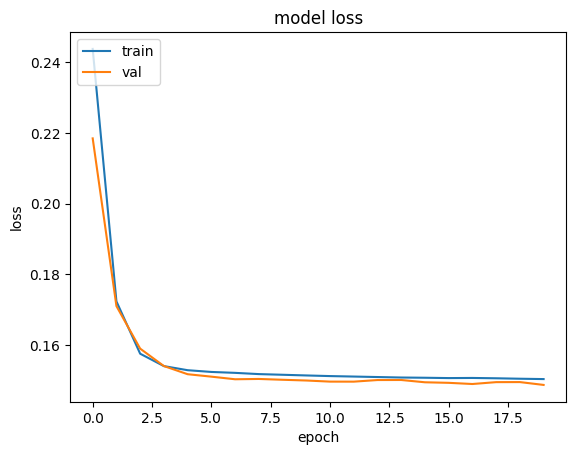

In [49]:
plot_loss(stacked_auto_encoder.history.history)

**Finetune the model by adding logistic regression layer**

In [50]:
# Create a 1 hot encoded Y_train
def create_one_hot(arr):
    out_arr = []
    for item in arr:
        max_arr = max(arr)
        one_hot_encoded = [0] * (max_arr+1)
        one_hot_encoded[item] = 1
        out_arr.append(one_hot_encoded)
    return np.array(out_arr)

Y_train_hot_encoded = create_one_hot(Y_train)
Y_val_hot_encoded = create_one_hot(Y_val)

In [51]:
fine_tuned_model, fine_tuned_encoder = stacked_auto_encoder.finetune(X_train_scaled, Y_train_hot_encoded, X_val_scaled, Y_val_hot_encoded, 30, 1) 

Epoch 1/30
888/895 [============================>.] - ETA: 0s - loss: 2.6943
Epoch 1: val_loss improved from inf to 1.64612, saving model to weights.hdf5
895/895 [==============================] - 5s 4ms/step - loss: 2.6881 - val_loss: 1.6461
Epoch 2/30
889/895 [============================>.] - ETA: 0s - loss: 1.2190
Epoch 2: val_loss improved from 1.64612 to 0.97232, saving model to weights.hdf5
895/895 [==============================] - 5s 5ms/step - loss: 1.2208 - val_loss: 0.9723
Epoch 3/30
892/895 [============================>.] - ETA: 0s - loss: 0.6950
Epoch 3: val_loss improved from 0.97232 to 0.67236, saving model to weights.hdf5
895/895 [==============================] - 4s 4ms/step - loss: 0.6929 - val_loss: 0.6724
Epoch 4/30
888/895 [============================>.] - ETA: 0s - loss: 0.4787
Epoch 4: val_loss improved from 0.67236 to 0.33752, saving model to weights.hdf5
895/895 [==============================] - 4s 4ms/step - loss: 0.4755 - val_loss: 0.3375
Epoch 5/30
895/8

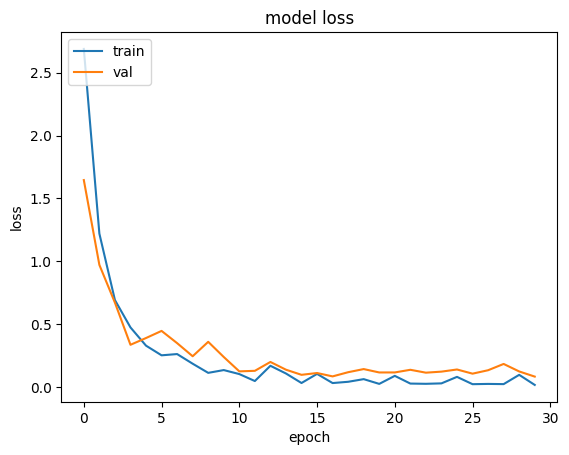

In [52]:
plot_loss(stacked_auto_encoder.history.history)

**Now feed the encoded representation into linear SVM**

In [53]:
X_train_encoded = fine_tuned_encoder.predict(X_train_scaled)

# Fit to encoded data
svm_autoencoder = SVC(kernel='linear', C=1)
svm_autoencoder.fit(X_train_encoded, Y_train)

# Encode the test data and use SVM to predict its labels
X_test_encoded = fine_tuned_encoder.predict(X_test_scaled)
predicted = svm_autoencoder.predict(X_test_encoded)

print(Y_test)
print("########################")
print(predicted)

print("SVM Accuracy Score -> ", metrics.accuracy_score(predicted, Y_test)*100)

predicted_train = svm_autoencoder.predict(X_train_encoded)
print("SVM Accuracy Score on training -> ", metrics.accuracy_score(predicted_train, Y_train)*100)

X_val_encoded = fine_tuned_encoder.predict(X_val_scaled)
predicted_val = svm_autoencoder.predict(X_val_encoded)
print("SVM Accuracy Score on validation -> ", metrics.accuracy_score(predicted_val, Y_val)*100)

14/14 [==============================] - 0s 2ms/step
[ 3 11  5 25 13 25  4  3 25 25 25  3 29 11 15 29 25  5 13 13  3 24 24 24
 13 13 13 13 29 11 14 23 11 24 24 24 13 24 24 24 24 24 29 20 20 11  5  7
  7 24 24  7  5  5 13 13  7  7  7 19  7  7 11  7  7 28 28  7  7 27 28 28
 28 28 28 28 28 28 28 28 28 27 27  5  4  9  4  4 29  4  4 29 23  5 17 17
 17 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 23 26 12 12  3  4  4  4  4  4  4 27 27 27 15 26 27  0 23 15 15 15
 23 16 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 26 29 23 26 13  0 23
 23 23  9 23 23 23 27 27 27 27 27 29  9 12 27 14 14 14 14 14 14 14 14 14
 14 14 14  8  8 27 27 15 15 14  9  5 20 15 15 15 15  8  8  8  8  8  8  8
  8  8  9 14 20 20 19  3 20  5 20 15 25 13  0  5 29 29  9  7 29  5 20  4
 15 21  7 16 26 16 21 11 11 20 11 20 20  9 15 26  0  9  6  6 26  6  6 10
 10 10  6  1  1  1  1  1  1  1  1  1  1  1 21 11 13  3 23 16 24 10 10 10
 10  1 21  1  6 10  1  6 10 10 21 21 21 10 21 16  1 21 21 10  6 21 16  

In [54]:
print(metrics.classification_report(Y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.94      1.00      0.97        15
           2       1.00      1.00      1.00        15
           3       0.94      1.00      0.97        15
           4       1.00      1.00      1.00        14
           5       1.00      0.86      0.92        14
           6       1.00      1.00      1.00        15
           7       0.94      1.00      0.97        15
           8       0.93      0.87      0.90        15
           9       1.00      1.00      1.00        15
          10       1.00      0.93      0.97        15
          11       0.88      1.00      0.94        15
          12       1.00      0.93      0.96        14
          13       1.00      0.93      0.97        15
          14       1.00      1.00      1.00        15
          15       0.88      1.00      0.94        15
          16       1.00      0.93      0.97        15
          17       0.93    

In [55]:
print(metrics.cohen_kappa_score(Y_test, predicted))

0.9628874557936343


In [56]:
print(metrics.matthews_corrcoef(Y_test, predicted))

0.9629675904557704
